# ------------------------------
# 🏠 Mumbai House Price Prediction using XGBoost
# ------------------------------
# Author: [Amritanshu]
# Date: [June'2025]
# Description: This script loads real estate data from Mumbai,
# preprocesses categorical features, builds an XGBoost regression model,
# evaluates performance, and enables future price predictions.
# ------------------------------

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [82]:
df = pd.read_csv('Mumbai House Prices.csv')

In [83]:
df.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [84]:
df.info() 
# no null value so no need to df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bhk         76038 non-null  int64  
 1   type        76038 non-null  object 
 2   locality    76038 non-null  object 
 3   area        76038 non-null  int64  
 4   price       76038 non-null  float64
 5   price_unit  76038 non-null  object 
 6   region      76038 non-null  object 
 7   status      76038 non-null  object 
 8   age         76038 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ MB


# ------------------------------
#  Convert Price to Crores
# ------------------------------

In [85]:
def price_final(price, price_unit):
    if price_unit == 'L':
        return price / 100  # since 1 Cr = 100 L
    elif price_unit == 'Cr':
        return price        # already in Cr
    else:
        return price / 1e7 

In [86]:
df['price_in_rupees (in Crs)'] = df.apply(lambda row: price_final(row['price'], row['price_unit']), axis=1)
df.drop(columns=['price', 'price_unit'], inplace=True)

In [87]:
df.head()

,bhk,type,locality,area,region,status,age,price_in_rupees (in Crs)
0,3,Apartment,Lak And Hanware The Residency Tower,685,Andheri West,Ready to move,New,2.5000
1,2,Apartment,Radheya Sai Enclave Building No 2,640,Naigaon East,Under Construction,New,0.5251
2,2,Apartment,Romell Serene,610,Borivali West,Under Construction,New,1.7300
3,2,Apartment,Soundlines Codename Urban Rainforest,876,Panvel,Under Construction,New,0.5998
4,2,Apartment,Origin Oriana,659,Mira Road East,Under Construction,New,0.9411


In [88]:
df.value_counts('region')

region
Thane West             14868
Mira Road East          9902
Dombivali               3041
Kandivali East          2568
Kharghar                2362
                       ...  
Rambaug                    1
Police Colony              1
Pestom Sagar Colony        1
Pen                        1
vile parle west            1
Name: count, Length: 228, dtype: int64

In [89]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

#Why XGB regressor
# XGBRegressor is a powerful and efficient gradient boosting algorithm that often outperforms other models on structured/tabular data.

# Define Features and Target our aim is 'Price Prediction'

In [90]:
X = df.iloc[:, :-1]
y = df['price_in_rupees (in Crs)']

In [91]:
# Encode Categorical Features
category_features = ['type', 'locality', 'region', 'status', 'age']
le_dict = {} # Dictionary to store LabelEncoders for reuse

for feature in category_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str)) # Convert to str in case of NaNs or numeric
    X[feature] = X[feature].astype("category")  # Needed for XGBoost categorical support
    le_dict[feature] = le # Save encoder for later use

In [92]:
# Filter localities with at least 30 entries
valid_localities = X['locality'].value_counts()
valid_localities = valid_localities[valid_localities >= 30].index


# Apply both filters
X_filtered = X[X['locality'].isin(valid_localities) ]
# Align y with the filtered X
y_filtered = y.loc[X_filtered.index]

# Optionally overwrite X and y
X = X_filtered
y = y_filtered


In [93]:
# Step 3: Train-test split with stratification (on locality, since now it's encoded)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=X['region']  # Already encoded
)

In [94]:
# Step 4: Train XGBoost model with categorical support
model = XGBRegressor(
    tree_method='hist',
    enable_categorical=True,
    learning_rate=0.1,
    random_state=42
)


# Train the model

In [95]:
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [96]:
predictions = model.predict(X_test)

In [97]:
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2:.2f}")

R2 Score: 0.96


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(f"RMSE: {rmse:.2f} Cr")
print(f"MAE: {mae:.2f} Cr")

RMSE: 0.28 Cr
MAE: 0.12 Cr


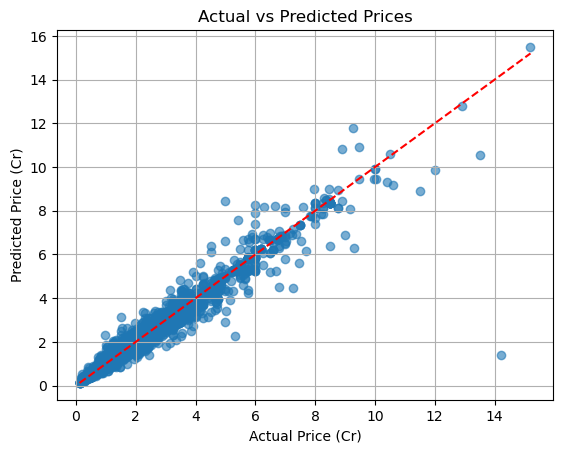

In [99]:
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (Cr)")
plt.ylabel("Predicted Price (Cr)")
plt.title("Actual vs Predicted Prices")
plt.grid(True)
plt.show()

In [100]:
import joblib
joblib.dump(model, 'mumbai_house_price_model.pkl')

['mumbai_house_price_model.pkl']

In [101]:
# Sample input (raw form)
new_data = {
    'bhk': [2], 
    'type': ['Studio Apartment'],
    'locality': ['Godrej Urban Park'],
    'area': [1000], 
    'region': ['Powai'],
    'status': ['Ready to move'],
    'age': ['New'],         
}

# Convert to DataFrame
new_df = pd.DataFrame(new_data)

# Encode categorical features using the same encoders
for feature in category_features:
    new_df[feature] = le_dict[feature].transform(new_df[feature])
    new_df[feature] = new_df[feature].astype("category")

# Predict
predicted_price = model.predict(new_df)
print(f"Predicted Price: ₹{predicted_price[0]:,.2f} Cr")

Predicted Price: ₹1.38 Cr
